In [4]:
import numpy as np
import os
from PIL import Image
import csv
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.utils.validation import check_is_fitted
from sklearn.utils import check_array, check_X_y
from sklearn import manifold
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier,RadiusNeighborsClassifier
from sklearn.utils import shuffle
from scipy.sparse import coo_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
from keras.utils.np_utils import to_categorical
from sklearn.metrics import plot_confusion_matrix

# File path

In [5]:
train_img_path = './train_images'
test_img_path = './test_images'
train_label_file = 'train.csv'
test_label_file = 'test.csv'

In [6]:
train_img = []
train_label = []
test_img = []

# Data Augmentation

In [7]:
Is_Rotate = False

# LOAD IMAGE

In [5]:
img = 0
trans_img = 0
for file in os.listdir(train_img_path):
    img = Image.open(train_img_path + '/' + file).resize((256,256),Image.BILINEAR)
    img = img.resize((128,128))
    im = np.array(img).reshape(-1)
    train_img.append(im)
    if Is_Rotate:
        l_img = img.rotate(15)
        im = np.array(img).reshape(-1)
        train_img.append(im)
        r_img = img.rotate(-15)
        im = np.array(img).reshape(-1)
        train_img.append(im)
        hori_img = transforms.RandomHorizontalFlip()
        vert_img = transforms.RandomVerticalFlip()
        pil_img_H = hori_img(img)
        pil_img_V = vert_img(img)
        train_img.append(np.array(pil_img_H).reshape(-1))
        train_img.append(np.array(pil_img_V).reshape(-1))
train_img = np.array(train_img)

In [8]:
i = 0
d = {0:0,1:0,2:0,3:0,4:0,5:0}
with open(train_label_file, newline = '') as csvfile:
    rows = csv.reader(csvfile)
    for row in rows:
        if i != 0:
            d[int(row[1])] += 1
            train_label.append(int(row[1]))
            if Is_Rotate:
                train_label.append(int(row[1]))
                train_label.append(int(row[1]))
                train_label.append(int(row[1]))
                train_label.append(int(row[1]))
        i = i + 1
train_label = np.array(train_label)
d
#train_label.shape

{0: 674, 1: 492, 2: 100, 3: 378, 4: 240, 5: 644}

In [7]:
train_img_sparse = coo_matrix(train_img)
train_img,train_img_sparse,train_label = shuffle(train_img,train_img_sparse,train_label,random_state=0)

In [8]:
# img = 0
# trans_img = 0
# test_img=[]
# for file in os.listdir(test_img_path):
#     img = Image.open(test_img_path + '/' + file).resize((128,128),Image.BILINEAR)
#     im = np.array(img).reshape(-1)
#     test_img.append(im)
    
# test_img = np.array(test_img)
#img

In [9]:
train_img.shape
#test_img.shape

(12640, 16384)

# Predict Function

In [10]:
def predict_accuracy(y, y_hat):
    return sum(y == y_hat) / y.shape[0]

# PCA

In [11]:
def PCA_decomposition(pca, train_img):
    #pca = PCA(n_components=n_components)
    pipe = make_pipeline(StandardScaler(),pca)
    pca_img = pca.transform(train_img)
    pca_inv_img = pca.inverse_transform(pca_img)
#     img_compressed = (np.stack(pca_inv_img[-1],axis = 0)).astype(np.uint8)
#     img_pca = Image.fromarray(img_compressed.reshape(train_img.shape), 'L')
    return pca_img, pca_inv_img
    #     return pca_img

# split train and validation set

In [12]:
# use train image to split train and valid set 
X_train,X_test,Y_train,Y_test = train_test_split(train_img,train_label,test_size=0.0001,random_state=42)

#or use test image

# X_train = train_img
# Y_train = train_label
# X_test = test_img

In [13]:
print("X_train shape:",X_train.shape)
print("Y_train shape:",Y_train.shape)
print("X_test shape:",X_test.shape)
print("Y_test shape:",Y_test.shape)

X_train shape: (6320, 16384)
Y_train shape: (6320,)
X_test shape: (6320, 16384)
Y_test shape: (6320,)


In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
# X_train = X_train / 255.

# cumulative explained variance

Text(0, 0.5, 'cumulative explained variance')

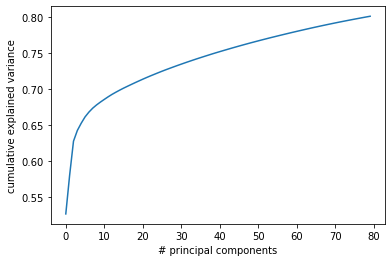

In [15]:
# pca_batch_data = 256
n_compons_rate = 0.8
pca = PCA(n_compons_rate)
pca.fit(X_train)
cum_explained_var_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cum_explained_var_ratio)
plt.xlabel('# principal components')
plt.ylabel('cumulative explained variance')

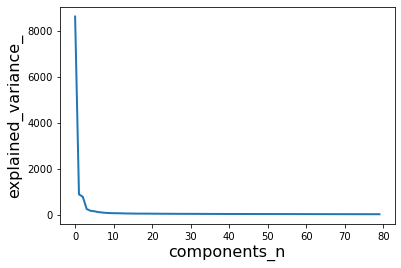

In [32]:
plt.plot(pca.explained_variance_,linewidth=2)
plt.xlabel('components_n', fontsize=16)
plt.ylabel('explained_variance_',fontsize=16)
plt.show()

In [16]:
print(pca.explained_variance_)
print(pca.components_)

[8626.41440257  882.32319673  772.8358177   243.40322887  164.40130703
  144.13221395  109.28872689   90.25317006   73.73865283   64.82362466
   60.27208332   59.01226714   54.89898779   49.47718236   47.28163041
   45.17877802   42.16014496   41.71238296   41.06268449   39.92952953
   39.3783112    38.27052539   37.16637093   35.68579772   35.62528815
   34.69449676   33.85483861   32.43737354   32.26910817   31.84908579
   31.00121468   30.70231872   30.02342564   29.56572307   29.21659842
   28.37566517   28.14907086   27.79913973   27.65766841   26.75461274
   26.11711266   25.93442275   25.65795015   25.55508073   25.06217446
   24.78747673   24.35645481   24.04199264   23.7731843    23.14590056
   23.02615928   22.82491136   22.53187874   22.39046715   21.66929196
   21.62893905   21.46721202   21.2274465    20.97141103   20.85524657
   20.43808476   20.23555517   20.09091772   19.9887702    19.69250474
   19.29518589   19.06841345   18.80001324   18.56202018   18.16153784
   18.

In [17]:

# pca_train_img,pca_inv_img= PCA_decomposition(n_compons_rate,X_train[:pca_batch_data])
# for i in range(pca_batch_data,X_train.shape[0],pca_data):
#         try:
#             pca_img,_= PCA_decomposition(n_comp,X_train[i:i+pca_batch_data])
#             print(pca_img.shape)
#             pca_train_img = np.concatenate([pca_train_img,pca_img])
#         except:
#             print(X_train[i:i+pca_data].shape)


# PCA降維 reconstruct結果

In [18]:
n_compons_rate = 0.8
transform_train,pca_inv_img= PCA_decomposition(pca,X_train)

label =  1


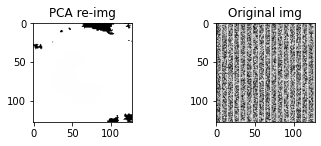

In [19]:
i = 37
print("label = ", Y_train[i])
re_img = pca_inv_img.reshape((pca_inv_img.shape[0],128,128)).astype(np.uint8)
img_pca = Image.fromarray(re_img[i] ,'L')
plt.subplot(2,2,1)
plt.title('PCA re-img')
plt.imshow(img_pca,cmap = "gray")
plt.subplot(2,2,2)
plt.title('Original img')
plt.imshow(Image.fromarray(X_train[i].reshape(128,128) ,'L'),cmap = "gray")
plt.show()

In [20]:
transform_test = pca.transform(X_test)
# for i in range(pca_data,X_test.shape[0],pca_data):
#     try:
#         pca_t_img,_ = PCA_decomposition(n_comp,X_test[i:i+pca_data])
#         pca_test_img = np.concatenate([pca_test_img,pca_t_img])
#     except:
#         re_test = (int(X_test[i:i+pca_data].shape[0]*0.9))
#         print(re_test)
#         pca_remain_img ,_= PCA_decomposition(re_test,X_test[i:i+pca_data])

In [21]:
transform_train.shape, transform_test.shape

((6320, 80), (6320, 80))

In [22]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(transform_train,Y_train)
res = knn.predict(transform_test)
res

array([1, 1, 1, ..., 0, 3, 1])

In [23]:
ans = predict_accuracy(res,Y_test)
ans

0.9428797468354431

## SVM test

In [24]:
# from sklearn import svm

In [25]:
# clf = svm.SVC()
# clf.fit(transform_train,Y_train)
# res = clf.predict(transform_test)
# res

In [26]:
# dic = {0 : 0, 1 : 0, 2 : 0, 3: 0, 4: 0, 5 : 0}
# for i in range(len(res)):
#     if res[i] != Y_test[i]:
#         dic[Y_test[i]] += 1
# dic

In [27]:
# ans = predict_accuracy(res,Y_test)
# ans

In [28]:
# import pandas as pd
# df = pd.read_csv(test_label_file)
# df = df.loc[:,['ID','Label']]
# df.Label = res.astype(int)
# df.head()
# df.to_csv('submission.csv', index=False)

In [29]:
import numpy as np

class Encoder(object):
    def __init__(self,class_number,start_with=0):
        self._start_with = 0
        self._n_class = class_number
    
    def one_hot_encode(self,x):
        y = np.zeros(self._n_class,dtype=float)
        y[x - self._start_with] = 1
        return y
    
    def label(self,X):
        return np.argmax(X) + self._start_with

In [30]:
encoder = Encoder(6)

In [1]:
# y_pred = res
# y_true = Y_test
# #y_pred = to_categorical(res, num_classes=6)
# #y_true = to_categorical(Y_test, num_classes=6)
# target_names = [ 'Normal','Void' ,'Hor','Ver','Edge','Par']
# #print ("PCA + SVC")
# print(classification_report(y_true, y_pred, target_names=target_names))
# print ("**************************************************************")

# plt.figure(figsize=(100, 100))
# #cnf_matrix = confusion_matrix(y_true, y_pred)
# disp = plot_confusion_matrix(knn, transform_test,Y_test, display_labels=target_names,normalize='true')
# disp.ax_.set_title("PCA + KNN Predict Confusion Matrix")

# plt.show()

NameError: name 'res' is not defined